/home/niz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/niz/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


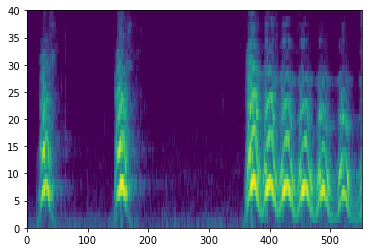

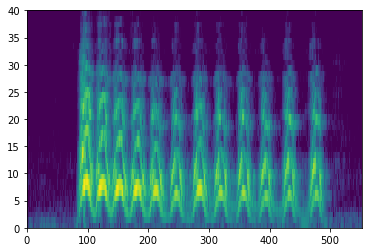

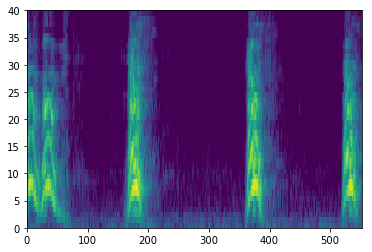

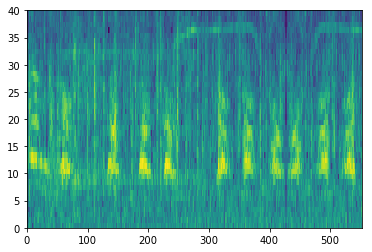

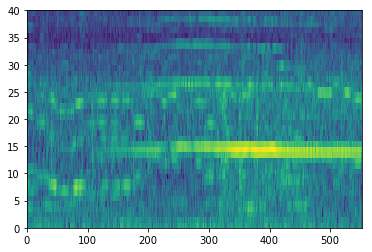

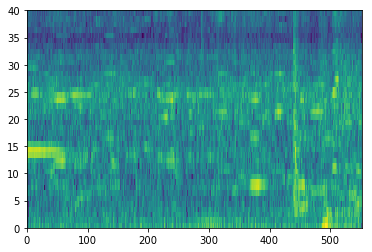

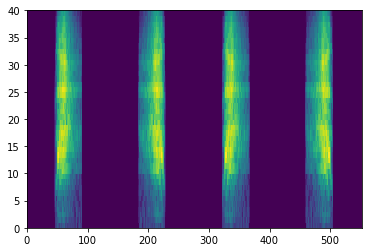

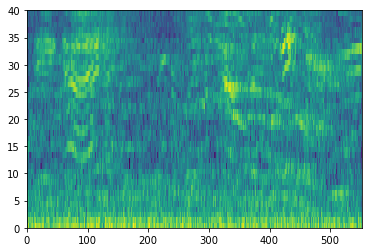

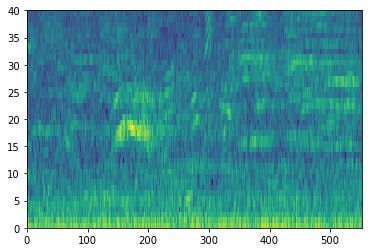

In [1]:
import os
import sys
sys.path.append('../common')
import shutil
import pandas as pd
import numpy as np
import keras
import keras.backend as K
from matplotlib import pyplot as plt
from mixup_generator import MixupGenerator
from random_eraser import get_random_eraser
from cyclic_lr import CyclicLR

TRY = 'T3'

# Load as is
X_train = np.load('X_train.npy')
y_train = keras.utils.to_categorical(np.load('y_train.npy'))
X_valid = np.load('X_valid.npy')
y_valid = keras.utils.to_categorical(np.load('y_valid.npy'))
X_test = np.load('X_test.npy')
y_test = keras.utils.to_categorical(np.load('y_test.npy'))

# Make label lists
labels = ['air_conditioner',  'car_horn', 'children_playing', 'dog_bark', 'drilling',
    'engine_idling', 'gun_shot','jackhammer', 'siren', 'street_music']
label2int = {l:i for i, l in enumerate(labels)}
int2label = {i:l for i, l in enumerate(labels)}

# Normalize dataset
value_max = np.max(np.vstack([X_train, X_valid, X_test]))
X_train = X_train / value_max
X_valid = X_valid / value_max
X_test = X_test / value_max

# [:, 40, 552] -> [:, 40, 552, 1]
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Confirmation
def plot_dataset(X, n=3):
    for i in range(n):
        x = X[i]
        plt.pcolormesh(x[..., -1])
        plt.show()
for X in [X_train, X_valid, X_test]:
    plot_dataset(X)

In [2]:
import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Activation, Dropout, BatchNormalization, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, TensorBoard

def model_cnn_alexnet(input_shape): # AlexNet based
    model = Sequential()
 
    model.add(Conv2D(48, 11,  input_shape=input_shape, strides=(2,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(3, strides=(1,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, 5, strides=(2,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(3, strides=2))
    model.add(BatchNormalization())

    model.add(Conv2D(192, 3, strides=1, activation='relu', padding='same'))
    model.add(Conv2D(192, 3, strides=1, activation='relu', padding='same'))
    model.add(Conv2D(128, 3, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling2D(3, strides=(1,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [3]:
batch_size = 32 
num_classes = len(labels)
epochs = 150

callbacks = [
    CyclicLR(base_lr=0.00007, max_lr=0.0007, step_size=X_train.shape[0] // batch_size, mode='triangular'),
    ModelCheckpoint('model%s4.h5' % TRY,
                monitor='val_acc',
                verbose=1,
                save_best_only=True,
                save_weights_only=True),
     keras.callbacks.TensorBoard(log_dir='./%slog' % TRY, histogram_freq=0, write_graph=True, write_images=True)
]

datagen = ImageDataGenerator(
    featurewise_center=True,  # set input mean to 0 over the dataset
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.4,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    #preprocessing_function=get_random_eraser(v_l=np.min(X_train), v_h=np.max(X_train)) # RANDOM ERASER
)
#mixupgen = MixupGenerator(X_train, y_train, alpha=1.0, batch_size=batch_size, datagen=datagen)
test_datagen = ImageDataGenerator(
    featurewise_center=True,  # set input mean to 0 over the dataset
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(np.r_[X_train, X_valid, X_test])
test_datagen.mean, test_datagen.std = datagen.mean, datagen.std

In [4]:
model = model_cnn_alexnet(X_train.shape[1:])
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 184, 48)       5856      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 91, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 91, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 31, 128)        153728    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 15, 128)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 15, 128)        512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 15, 192)        221376    
__________

In [5]:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=test_datagen.flow(X_valid, y_valid), callbacks=callbacks)

Epoch 1/150
184/186 [============================>.] - ETA: 0s - loss: 2.2438 - acc: 0.2622
Epoch 00001: val_acc improved from -inf to 0.35051, saving model to weightsT34valid
186/186 [==============================] - 5s 24ms/step - loss: 2.2418 - acc: 0.2629 - val_loss: 1.9223 - val_acc: 0.3505
Epoch 2/150
183/186 [============================>.] - ETA: 0s - loss: 1.6227 - acc: 0.4398
Epoch 00002: val_acc improved from 0.35051 to 0.52323, saving model to weightsT34valid
186/186 [==============================] - 4s 22ms/step - loss: 1.6175 - acc: 0.4411 - val_loss: 1.4760 - val_acc: 0.5232
Epoch 3/150
184/186 [============================>.] - ETA: 0s - loss: 1.3914 - acc: 0.5230
Epoch 00003: val_acc did not improve
186/186 [==============================] - 4s 22ms/step - loss: 1.3908 - acc: 0.5233 - val_loss: 2.0550 - val_acc: 0.4192
Epoch 4/150
184/186 [============================>.] - ETA: 0s - loss: 1.2806 - acc: 0.5739
Epoch 00004: val_acc improved from 0.52323 to 0.56768, sav

Epoch 32/150
184/186 [============================>.] - ETA: 0s - loss: 0.2658 - acc: 0.9113
Epoch 00032: val_acc did not improve
186/186 [==============================] - 4s 23ms/step - loss: 0.2653 - acc: 0.9115 - val_loss: 1.8120 - val_acc: 0.6677
Epoch 33/150
183/186 [============================>.] - ETA: 0s - loss: 0.2246 - acc: 0.9273
Epoch 00033: val_acc did not improve
186/186 [==============================] - 4s 22ms/step - loss: 0.2255 - acc: 0.9266 - val_loss: 2.2186 - val_acc: 0.5929
Epoch 34/150
183/186 [============================>.] - ETA: 0s - loss: 0.2726 - acc: 0.9108
Epoch 00034: val_acc did not improve
186/186 [==============================] - 4s 23ms/step - loss: 0.2713 - acc: 0.9115 - val_loss: 2.0036 - val_acc: 0.6434
Epoch 35/150
185/186 [============================>.] - ETA: 0s - loss: 0.2177 - acc: 0.9304
Epoch 00035: val_acc did not improve
186/186 [==============================] - 4s 23ms/step - loss: 0.2179 - acc: 0.9306 - val_loss: 2.1033 - val_acc:

183/186 [============================>.] - ETA: 0s - loss: 0.0673 - acc: 0.9766
Epoch 00096: val_acc did not improve
186/186 [==============================] - 4s 24ms/step - loss: 0.0663 - acc: 0.9770 - val_loss: 2.8376 - val_acc: 0.6273
Epoch 97/150
183/186 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.9804
Epoch 00097: val_acc did not improve
186/186 [==============================] - 4s 23ms/step - loss: 0.0681 - acc: 0.9805 - val_loss: 2.7717 - val_acc: 0.6242
Epoch 98/150
185/186 [============================>.] - ETA: 0s - loss: 0.0710 - acc: 0.9789
Epoch 00098: val_acc did not improve
186/186 [==============================] - 4s 22ms/step - loss: 0.0707 - acc: 0.9790 - val_loss: 2.5976 - val_acc: 0.6414
Epoch 99/150
183/186 [============================>.] - ETA: 0s - loss: 0.0744 - acc: 0.9797
Epoch 00099: val_acc did not improve
186/186 [==============================] - 4s 23ms/step - loss: 0.0789 - acc: 0.9792 - val_loss: 3.0948 - val_acc: 0.5980
Epoch

Epoch 129/150
183/186 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9874
Epoch 00129: val_acc did not improve
186/186 [==============================] - 4s 22ms/step - loss: 0.0352 - acc: 0.9872 - val_loss: 2.8914 - val_acc: 0.6111
Epoch 130/150
184/186 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9881
Epoch 00130: val_acc did not improve
186/186 [==============================] - 4s 22ms/step - loss: 0.0399 - acc: 0.9881 - val_loss: 2.6898 - val_acc: 0.6535
Epoch 131/150
185/186 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9912
Epoch 00131: val_acc did not improve
186/186 [==============================] - 4s 22ms/step - loss: 0.0282 - acc: 0.9913 - val_loss: 3.5888 - val_acc: 0.5869
Epoch 132/150
183/186 [============================>.] - ETA: 0s - loss: 0.1072 - acc: 0.9710
Epoch 00132: val_acc did not improve
186/186 [==============================] - 4s 22ms/step - loss: 0.1070 - acc: 0.9711 - val_loss: 2.5954 - val_

In [6]:
# CONFIRMATION ON INITIAL TRAINING
model.load_weights('model%s4.h5' % TRY)
y_valid_preds = model.predict_generator(test_datagen.flow(X_valid, y_valid, shuffle=False))
y_valid_pred_cls = [np.argmax(pred) for pred in y_valid_preds]
y_valid_refs = [np.argmax(y) for y in y_valid]

np.save('preds%s4valid.npy' % TRY, y_valid_preds)
valid_results = [result == ref for result, ref in zip(y_valid_pred_cls, y_valid_refs)]

# accuracy
print(np.sum(valid_results)/len(valid_results))

# double check answers
for result, ref in zip(y_valid_pred_cls[:10], y_valid_refs[:10]):
    print(result, '\t', ref)

0.693939393939394
3 	 3
8 	 9
2 	 9
0 	 9
9 	 9
2 	 9
2 	 9
3 	 3
3 	 3
3 	 3


In [7]:
# CONFIRMATION w/ test set
model.load_weights('model%s4.h5' % TRY)
y_test_preds = model.predict_generator(test_datagen.flow(X_test, y_test, shuffle=False))
y_test_pred_cls = [np.argmax(pred) for pred in y_test_preds]
y_test_refs = [np.argmax(y) for y in y_test]
test_results = [result == ref for result, ref in zip(y_test_pred_cls, y_test_refs)]

# accuracy
print(np.sum(test_results)/len(test_results))

# double check answers
for result, ref in zip(y_test_pred_cls[:10], y_test_refs[:10]):
    print(result, '\t', ref)

0.7094017094017094
3 	 3
2 	 2
2 	 2
2 	 2
2 	 2
2 	 2
2 	 2
2 	 2
2 	 2
7 	 0
